In [50]:
import json
import os
from glob import glob

import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
from scipy.stats import entropy
from torchvision import datasets, transforms

In [51]:
trials_rs = []
for trial in glob('./cifar_random_*.jsonl'):
    rounds = [ json.loads(i) for i in open(trial) ]
    trials_rs.append(rounds)
    
trials_us = []
for trial in glob('./cifar_uncertainty_*.jsonl'):
    rounds = [ json.loads(i) for i in open(trial) ]
    trials_us.append(rounds)

In [52]:
dataset1 = datasets.CIFAR10('../../data', train=True, download=False)
dataset2 = datasets.CIFAR10('../../data', train=False, download=False)
dataset1.targets = np.array(dataset1.targets)
dataset2.targets = np.array(dataset2.targets)

<AxesSubplot:>

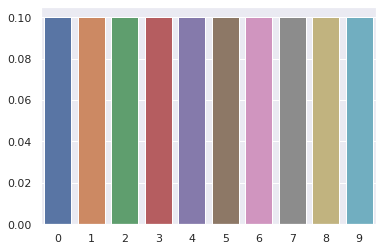

In [53]:
series = pd.Series(dataset1.targets).value_counts(normalize=True)
sns.barplot(x=series.index, y=[i for i in series])

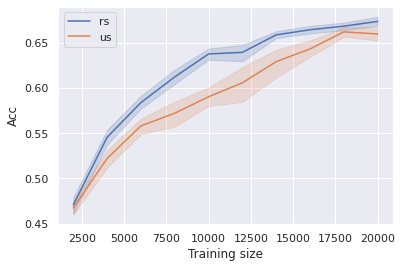

In [54]:
for samp, trials in [('rs', trials_rs), ('us', trials_us)]:
    x, y = [], []
    for rounds in trials:
        for round in rounds:
            train_idx = np.array(round['train_idx'])
            train_labels = dataset1.targets[train_idx]
            x.append(len(train_idx))
            y.append(round['test_acc'])

        #plt.figure()
    df = pd.DataFrame({'Training size' : x, 'Acc' : y})
    sns.lineplot(data=df, x='Training size', y='Acc', label=samp)

### Label entropy

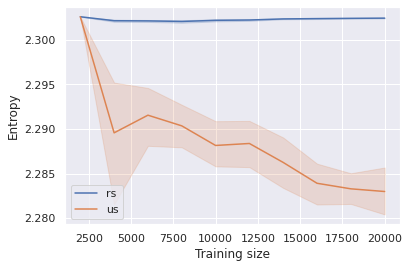

In [55]:
for samp, trials in [('rs', trials_rs), ('us', trials_us)]:
    x, y = [], []
    for rounds in trials:
        for round in rounds:
            train_idx = np.array(round['train_idx'])
            train_labels = dataset1.targets[train_idx]
            x.append(len(train_idx))

            counts = pd.Series(train_labels).value_counts()
            H = entropy(counts)
            y.append(H)

        #plt.figure()
    df = pd.DataFrame({'Training size' : x, 'Entropy' : y})
    sns.lineplot(data=df, x='Training size', y='Entropy', label=samp)

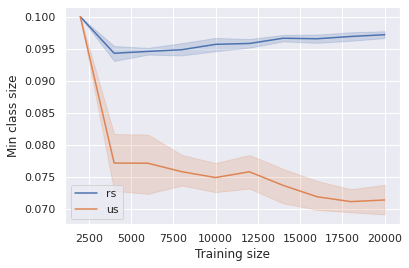

In [56]:
for samp, trials in [('rs', trials_rs), ('us', trials_us)]:
    x, y = [], []
    for rounds in trials:
        for round in rounds:
            train_idx = np.array(round['train_idx'])
            train_labels = dataset1.targets[train_idx]
            x.append(len(train_idx))

            counts = pd.Series(train_labels).value_counts()
            # minority classes
            y.append(counts.min() / counts.sum())

        #plt.figure()
    df = pd.DataFrame({'Training size' : x, 'Min class size' : y})
    sns.lineplot(data=df, x='Training size', y='Min class size', label=samp)

# Smallest group accuracy

In [57]:
dataset2.targets = np.array(dataset2.targets)

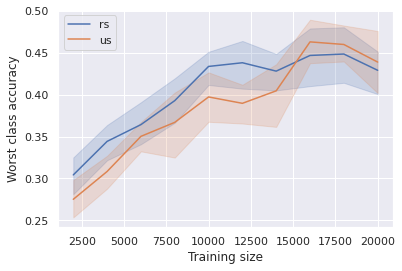

In [58]:
for samp, trials in [('rs', trials_rs), ('us', trials_us)]:
    x, y = [], []
    for rounds in trials:
        for round in rounds:
            train_idx = np.array(round['train_idx'])
            preds = round['test_predictions']
            
            df = pd.DataFrame({'labels' : dataset2.targets, 'predictions' : preds})
            df['correct'] = df['labels'] == df['predictions']

            df_label = df.groupby('labels')
            t = df_label.correct.mean().min()
            if t:
                x.append(int(len(train_idx)))
                y.append(t)

    df = pd.DataFrame({'Training size' : x, 'Worst class accuracy' : y})
    sns.lineplot(data=df, x='Training size', y='Worst class accuracy', label=samp)

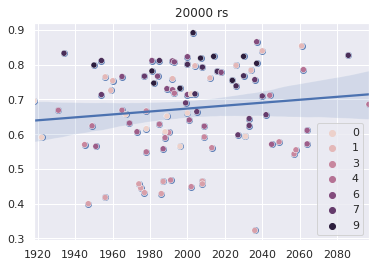

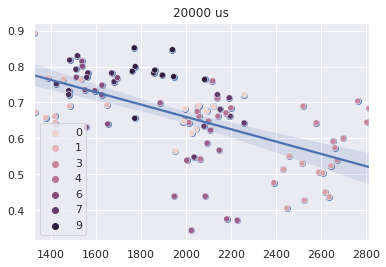

In [63]:
for samp, trials in [('rs', trials_rs), ('us', trials_us)]:
    x, y, z = [], [], []
    plt.figure()
    for rounds in trials:
        round = rounds[-1]
        train_idx = np.array(round['train_idx'])
        preds = round['test_predictions']
        df = pd.DataFrame({'labels' : dataset2.targets, 'predictions' : preds})
        df['correct'] = df['labels'] == df['predictions']

        df_label = df.groupby('labels')
        label_accs = df_label.correct.mean()
        
        train_labels = dataset1.targets[train_idx]
        label_counts = [ np.sum(train_labels == i) for i in range(0, 10) ]
        
        for c, a, t in zip(label_counts, label_accs, range(0,10)):
            x.append(c)
            y.append(a)
            z.append(t)
            
    plt.title('%d %s' % (len(train_idx), samp))
    sns.regplot(x=x, y=y)
    sns.scatterplot(x=x, y=y, hue=z)